In [286]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.metrics import accuracy_score,recall_score,precision_score,confusion_matrix,f1_score

### Import Data

In [287]:
df = pd.read_csv('data\cwdmappingdata_processed.csv')
print(list(df.columns))

C:\Users\chris\AppData\Local\Temp\ipykernel_11944\2532526995.py:1: DtypeWarning: Columns (9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,133,147,151,195,196,198) have mixed types. Specify dtype option on import or set low_memory=False.


['sample', 'survey', 'code', 'dob', 'gender', 'district', 'sector', 'cell', 'insurance_yn', 'reasonwhy_noinsurance', 'relationship1', 'relationship2', 'mumage_1stborn', 'mumage_this', 'dadage_1stborn', 'dadage_this', 'parentsrelated_yn', 'adopted_yn', 'orphan_yn', 'childposition', 'sibling1age', 'sibling2age', 'sibling3age', 'sibling4age', 'sibling5age', 'othersiblingages', 'attendantenatal_yn', 'attendantenatal_ntimes', 'pregcomplication_yn', 'pregcomplication_which', 'medication_yn', 'medicationfromwhere', 'childbornwhere', 'birthattendant_yn', 'birthattendant_who', 'birth_atwhatstage', 'birthweight', 'birthcomplication_yn', 'birthcomplication_which', 'wayofeatingdrinking', 'baby_fedhow', 'baby_solidseaten', 'solidmeals', 'vaccine_yn', 'nutritionalstatus', "Child's_weights_compared_to_his/her_age_(Latest_measures)", 'MUAC_(Current_measures)', 'growth_testedregularly_yn', 'Child_has_been_removed_amongest_those_with_anti-malnutrition_program_(For_last_6_months)', 'antimal_yn', 'explain

# Summary Statistics

In [288]:
#Show number of observations in each sample for each survey
pd.crosstab(index=df['sample'], columns=df['survey'], dropna=False, margins=True)

survey,under3,under5,under9,All
sample,,,,
22districts,1308,1158,1460,3926
3cells,1326,1053,1646,4025
All,2634,2211,3106,7951


In [289]:
#Show the proportion of children with a developmental delay or disability in each sample
pd.pivot_table(df, index='sample',columns='survey', values='delayordis',aggfunc=np.mean)

survey,under3,under5,under9
sample,,,
22districts,0.660880,0.484456,0.785616
3cells,0.094482,0.146249,0.159781


# Understanding the Strengths & Limitations of the Two Samples

### 3 Cells Sample
Strengths:
* All households in 3 cells were sampled so it enables a true estimate of disability in these places

Limitations:
* Only covers 3 cells out of 2148 (Rwanda is split into 30 districts, 416 sectors, 2148 cells and 14837 villages)

### 22 Districts Sample
Strengths:
* Households involved were spread over 22/30 districts of Rwanda
* Representative sample among children identified as having a disability

Limitations:
* Sampled from children whose parents or caregivers who brough their child forward to be mapped, the effect of negative stigma or not recognising disability in children could mean the types of disabilities are skewed

# Under 3 Developmental Delay Survey

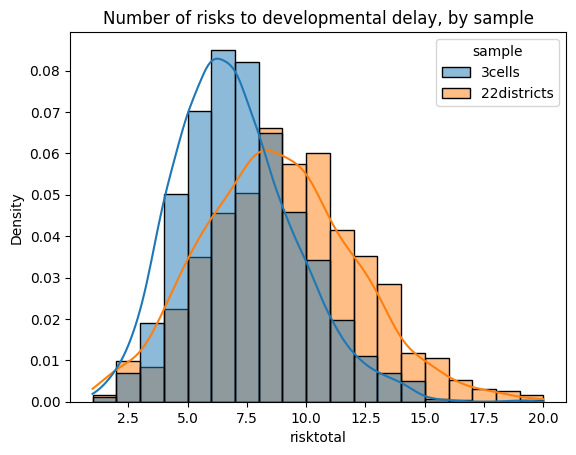

In [290]:
filtered=df['survey']=='under3'
sns.histplot(data=df[filtered],
    x='risktotal', 
    binwidth=1, 
    stat='density', 
    kde=True, 
    hue='sample').set(
        title='Number of risks to developmental delay, by sample')
plt.show()

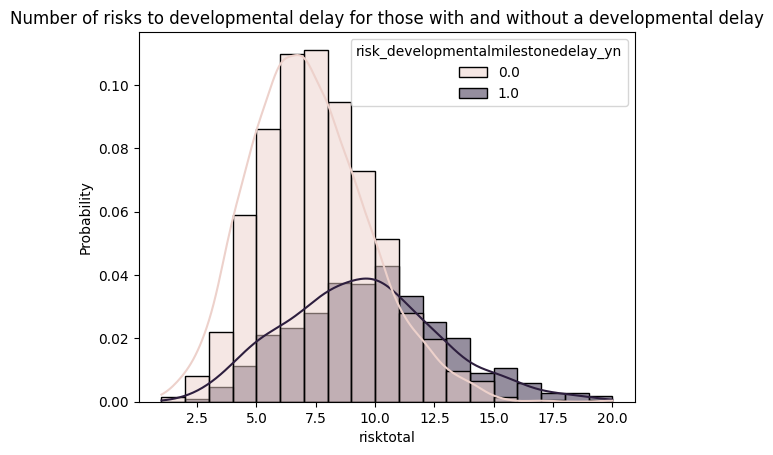

In [291]:
filtered=df['survey']=='under3'
sns.histplot(data=df[filtered],
    x='risktotal', 
    binwidth=1, 
    stat='probability', 
    kde=True, 
    hue='risk_developmentalmilestonedelay_yn').set(
        title='Number of risks to developmental delay for those with and without a developmental delay')
plt.show()


In [292]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#logistic regression: Do the risk catgeories predict a developmental delay? 

class DataPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        filtered = (X['survey'] == 'under3')
        data = X[['risk_developmentalmilestonedelay_yn', 'ubudehe1234', 'sample', 'sector', 'age', 'gender', 'familyrisks', 'birthrisks', 'childhealthrisks', 'socialrisks']][filtered].dropna()
        return data

class LogisticRegressionModel(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        formula = 'risk_developmentalmilestonedelay_yn ~ sample + age + gender + ubudehe1234 + familyrisks + birthrisks + childhealthrisks + socialrisks'
        self.model = smf.logit(formula=formula, data=X)
        self.result = self.model.fit()
        return self
    
    def transform(self, X, y=None):
        return X

# Assuming you have a DataFrame df
pipeline = Pipeline([
    ('preprocessor', DataPreprocessor()),
    ('model', LogisticRegressionModel())
])

pipeline.fit(df)
print(pipeline.named_steps['model'].result.summary())


params = pipeline.named_steps['model'].result.params
params
conf = result.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['5%', '95%','Odds Ratio']
confe=np.exp(conf)
confe['prob_5%']=(confe['5%']/(1+confe['5%']))    
confe['prob_odds']=(confe['Odds Ratio']/(1+confe['Odds Ratio']))
confe['prob_95%']=(confe['95%']/(1+confe['95%']))
confe[['prob_5%','prob_odds','prob_95%']]

Optimization terminated successfully.
         Current function value: 0.404890
         Iterations 6
                                    Logit Regression Results                                   
Dep. Variable:     risk_developmentalmilestonedelay_yn   No. Observations:                 1304
Model:                                           Logit   Df Residuals:                     1295
Method:                                            MLE   Df Model:                            8
Date:                                 Sun, 20 Aug 2023   Pseudo R-squ.:                  0.3075
Time:                                         13:39:37   Log-Likelihood:                -527.98
converged:                                        True   LL-Null:                       -762.47
Covariance Type:                             nonrobust   LLR p-value:                 3.144e-96
                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------

,prob_5%,prob_odds,prob_95%
Intercept,0.213802,0.388019,0.596490
sample[T.3cells],0.062395,0.084187,0.112675
age,0.451431,0.508037,0.564438
gender,0.386591,0.462129,0.539447
ubudehe1234,0.408025,0.461035,0.514941
familyrisks,0.421951,0.484876,0.548284
birthrisks,0.500321,0.538885,0.576989
childhealthrisks,0.564845,0.592518,0.619617
socialrisks,0.494293,0.518201,0.542025


In [293]:
#Assumptions of Logistic Regression
    #The relationship between the independent variables and the log-odds is linear
    #Independence of Errors: The observations should be independent of each other
    #no multicollinearity among the independent variables
    #Non-Perfect Separation: Perfect separation occurs when a combination of independent variables perfectly predicts the outcome.
    #No outliers
    #No endogeneity (when an independent variable is correlated with the error term)
    #Relevant independant variables
    #Homoscedasticity of residuals

In [294]:
#All risk columns 

dfrisk=df[['risk_developmentalmilestonedelay_yn',
'survey',
'sample',
#  'code',
 'gender',
 'insurance_yn',
 'relationship1',
 'relationship2',
 'age',
 'risk_mumage_1stborn',
 'risk_mumage_this',
 'risk_dadage_1stborn',
 'risk_dadage_this',
 'risk_parentsrelated_yn',
 'risk_orphan_yn',
 'child_position',
 'risk_pregcomplication',
 'risk_medication_yn',
 'risk_childbornwhere',
 'risk_birthattendant_who',
 'risk_birth_atwhatstage',
 'risk_birthweight',
 'risk_birthcomplication_which',
 'risk_wayofeatingdrinking',
 'risk_baby_fedhow',
 'risk_solidmeals',
 'risk_vaccine_yn',
 'risk_nutritionalstatus',
 'risk_health_condition',
 'risk_impairment_cat',
 'risk_mother_healthissue',
 'risk_father_healthissue',
 'risk_family_impairment',
 'risk_mother_schoollevel',
 'risk_father_schoollevel',
 'ubudehe1234',
 'risk_ubudehe',
 'risk_mother_daysworked',
 'risk_father_daysworked',
 'risk_child_where',
 'risk_playwithchild_ord',
 'risk_talktochild_ord',
 'risk_readtochild_ord',
 'risk_singtochild_ord',
 'risk_teachchild_ord',
 'risk_fathertakescare_yn']]

In [295]:
filtered = (dfrisk['survey']=='under3') & (dfrisk['sample']=='3cells')
y='risk_developmentalmilestonedelay_yn'
dfrisk = dfrisk[filtered].dropna(subset=y)
print(dfrisk.shape)

def get_regression_cols(data):
    i=0
    less=0.95
    cutoff=(1-less)*len(data.index)
    print("n/a cutoff: ",cutoff)

    reg_cols=[]
    for col in list(data.columns.values):
        na=data[col].isna().sum()
        if na<cutoff:
            if data[col].dtypes in ('float64','int64','uint8'):
                print(col,data[col].dtypes,"NAs: ",na)
                reg_cols.append(col)
        else:
            print("rejected: ",col,data[col].dtypes,na)
            i+=1
    print(f"Number of rejected columns: {i}")
    return reg_cols

reg_cols = get_regression_cols(dfrisk)
print(reg_cols)
print(dfrisk[reg_cols].shape)

(1323, 45)
n/a cutoff:  66.15000000000006
risk_developmentalmilestonedelay_yn float64 NAs:  0
gender int64 NAs:  0
rejected:  age float64 399
rejected:  risk_mumage_1stborn float64 67
risk_mumage_this float64 NAs:  19
rejected:  risk_dadage_1stborn float64 105
risk_dadage_this float64 NAs:  57
risk_parentsrelated_yn float64 NAs:  0
risk_orphan_yn float64 NAs:  0
rejected:  risk_pregcomplication float64 1069
risk_medication_yn float64 NAs:  0
risk_childbornwhere float64 NAs:  4
risk_birthattendant_who int64 NAs:  0
risk_birth_atwhatstage float64 NAs:  1
risk_birthweight float64 NAs:  0
rejected:  risk_birthcomplication_which float64 1090
risk_wayofeatingdrinking float64 NAs:  22
risk_baby_fedhow float64 NAs:  39
rejected:  risk_solidmeals float64 261
risk_vaccine_yn float64 NAs:  0
risk_nutritionalstatus float64 NAs:  0
risk_health_condition float64 NAs:  16
rejected:  risk_impairment_cat float64 1269
risk_mother_healthissue float64 NAs:  15
risk_father_healthissue float64 NAs:  7
risk_

### Using a Decision Tree Classifier to explore which risks are most important to classify a child with a developmental delay

In [296]:
from sklearn.tree import DecisionTreeClassifier

#Decision Tree
dfrisk = dfrisk[reg_cols]
data = pd.get_dummies(dfrisk).dropna() #.fillna(0)#Try auto-filtering out high NA Qs then dont fillNA
print(data.shape)
feature_cols = list(data.drop(y,axis=1).columns)
X =  data[feature_cols]# Features

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, data[y], test_size=0.2, random_state=42) # 80% training and 20% test

print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

(1155, 27)
Training Features Shape: (924, 26)
Training Labels Shape: (924,)
Testing Features Shape: (231, 26)
Testing Labels Shape: (231,)


In [297]:
from sklearn.model_selection import GridSearchCV

params =  {'class_weight':['balanced'],
    'criterion':['gini','entropy','log_loss'],
    'min_samples_leaf': np.arange(16,30, 2), #This reduces overfitting to a specific pool of samples
    'max_features':np.arange(5,10, 1),#This guarantees distilling the tool to =<10 features
    'max_leaf_nodes':np.arange(5,20, 1), #This guarantees the model is not too complicated
    'max_depth': [3,4,5,6,7], #Higher captures more complex relationships, lower is more interpretible
    }
    #Other paramter tuning options:
        # 'ccp_alpha':np.arange(0,1.5, 0.01),#Higher the alpha, the fewer the branches (simpler tree)
        # 'min_samples_split':np.arange(2,30, 1),
        # 'min_weight_fraction_leaf':np.arange(0,0.5, 0.1),
        

# Create gridsearch instance
grid = GridSearchCV(estimator=DecisionTreeClassifier(),
                    param_grid=params,
                    scoring='recall',
                    cv=5, #A higher number of folds provides a better estimation of how well your model generalizes to unseen data
                    n_jobs=-1,
                    verbose=2) #Last run: 38250 fits took 4m23s

# Fit the model
grid.fit(X_train, y_train)
# Assess the score
grid.best_score_, grid.best_params_

Fitting 5 folds for each of 7875 candidates, totalling 39375 fits


(0.8183823529411764,
 {'class_weight': 'balanced',
  'criterion': 'log_loss',
  'max_depth': 7,
  'max_features': 9,
  'max_leaf_nodes': 7,
  'min_samples_leaf': 16})

Accuracy: 0.9307359307359307
Root Mean Squared Error: 0.2631806779839076
recall score : 0.7777777777777778


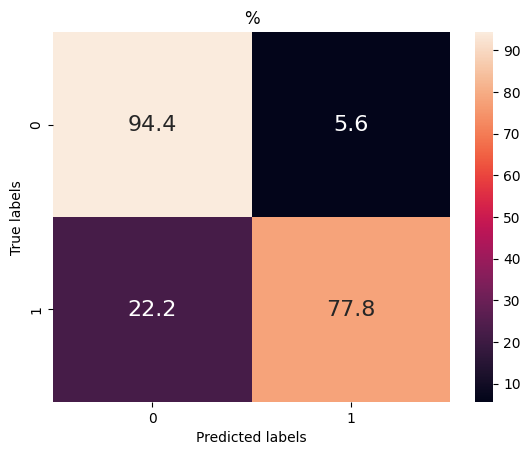

In [298]:
# grid.best_params_ = {'class_weight': 'balanced',
#                         'criterion': 'gini',
#                         'max_features': 16,
#                         'max_leaf_nodes': 11,
#                         'min_samples_leaf': 16}
clf = DecisionTreeClassifier(class_weight=grid.best_params_['class_weight']
                            , criterion=grid.best_params_['criterion']
                            , max_features=grid.best_params_['max_features']
                            , max_leaf_nodes=grid.best_params_['max_leaf_nodes']
                            , min_samples_leaf=grid.best_params_['min_samples_leaf']
                            , max_depth=grid.best_params_['max_depth']
                            , random_state = 42) 
                            # , ccp_alpha=grid.best_params_['ccp_alpha']
                            # , min_weight_fraction_leaf=grid.best_params_['min_weight_fraction_leaf']
clf.fit(X_train,y_train)
#Predict the response for test dataset
y_pred = clf.predict(X_test)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("recall score : "+str(recall_score(y_test,y_pred)))   # tp/tp+fn
ax=plt.subplot()
cm = metrics.confusion_matrix(y_test,y_pred, normalize='true')
sns.heatmap(cm*100,annot=True,fmt='.1f',annot_kws={"size":16})
ax.set_title('%');ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
plt.show()

c:\Users\chris\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


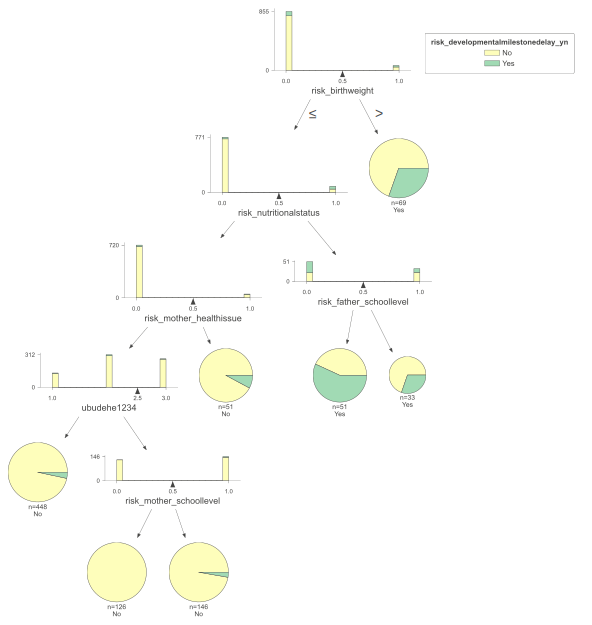

In [299]:
import dtreeviz # remember to load the package

viz_model = dtreeviz.model(clf,
                           X_train=X_train, 
                           y_train=y_train.astype(int),
                           feature_names=data[feature_cols].columns,
                           target_name='risk_developmentalmilestonedelay_yn',
                           class_names={1:'Yes',0:'No'})#['Yes','No'])#

v = viz_model.view()     # render as SVG into internal object 
v.save("tree_model_viz.svg")  # optionally save as svg
v

# Under 5 & Under 9 Washington Group Child Function Questionnaire

           disability3          
sample          3cells          
survey          under5    under9
district                        
nyamagabe     0.227907  0.102804
nyamasheke    0.041667  0.191406
nyarugenge    0.138264  0.201220


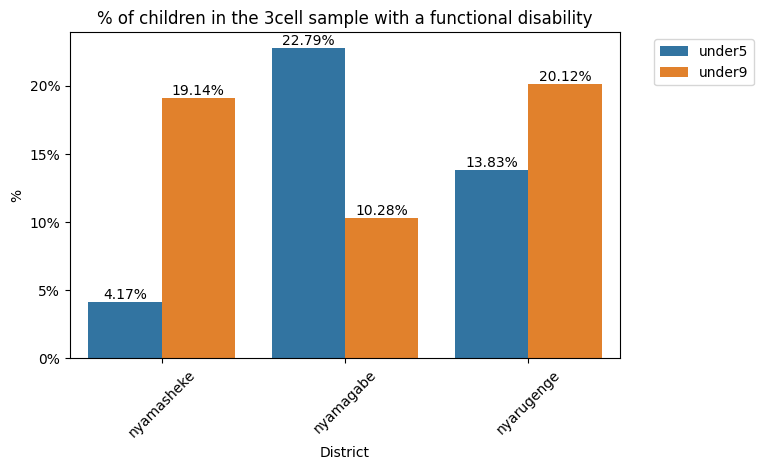

In [300]:
filtered=(df['survey']!='under3') & (df['sample']=='3cells') #& ((df['district']=='nyamagabe') | (df['district']=='nyamasheke') | (df['district']=='nyarugenge'))
df1=df[['sample','survey','sector','gender','ubudehe1234','district','disability3','seeing3', 'hearing3', 'walking3','motor3', 'understanding3', 'learning3', 'behavioural3', 'mental3']]
df1=df1[filtered]

pivot = pd.pivot_table(data=df1,index=['district'],columns=['sample','survey']
                      ,values=['disability3'], aggfunc=np.mean)
print(pivot)

# Create the bar plot using Seaborn
ax = sns.barplot(x='district', y='disability3',hue='survey', data=df1, errorbar=None)

plt.title("% of children in the 3cell sample with a functional disability")
plt.xlabel("District")
plt.ylabel("%")
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()

# Annotate each bar with its percentage value
for p in ax.patches:
    ax.annotate(f"{p.get_height()*100:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')
# Change y-axis labels to percentages (times by hundred)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x*100:.0f}%"))

# Move the legend outside the chart area
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()